# 1. Quasi-Newton methods

While Newton's method is a powerful technique that exhibits rapid convergence for a (especially) convex function $g\left(\mathbf{w}\right)$, it is naturally constrained by $N$ the dimension of the input $\mathbf{w}$.  In particular it is the quadratic generating Hessian $\nabla^2g\left(\mathbf{w}\right)$, an $N\times N$ matrix that limits Newton's method's use to cases where (roughly speaking) $N$ is at most in the thousands, since it is difficult to even store such a matrix when $N$ is larger (let alone compute with it).  In this Section we discuss a basic twist on Newton's method, where we replace th Hessian with an appropriate approximation, in order to avoid this restriction.  Collectively such techniques are  referred to as *quasi-Newton's methods'.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')

from mlrefined_libraries import math_optimization_library as optilearn

import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   # The only autograd function you may ever need

import math
import pandas as pd
import copy

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# 1.  Newton's method from the perspective of the gradient function

We have just seen how Newton's method works to find stationary points of a cost function, points where the gradient of the cost function is zero, effectively minimizing the function.  However the classic application of Newton's method is actually towards finding the *zeros* of (polynomial) functions - that is where a function crosses the input plane (or 'x axis' in one dimension).  At first glance it may not seem like the Newton's method - at least the way we have viewed it thus far - is applicable to such problems.  That is until we think about what Newton's method is doing in the space where the *gradient of our cost function* lives.  If Newton's method does indeed take steps towards finding the stationary point of a cost function then then we can we can indeed view these steps evaluated not on the cost function, but on the derivative (or gradient more generally) itself.  Any sequence of steps moving twoards a stationary point of the cost function itself is - when evaluated by the gradient - a sequence of steps moving towards a zero.

## 1.1  Viewing Newton's method as a first order zero finder - when $N = 1$

Becaue we will be dealing with first and second derivatives here, in this Subsection we will use the common (more compact) 'prime' notation to denote the first and second derivative of $g(w)$, a function taking in a single dimensional input $w$

\begin{equation}
g^{\prime}(w) = \frac{\mathrm{d}}{\mathrm{d}w}g\left(w\right) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,g^{\prime\prime}(w) = \frac{\mathrm{d}^2}{\mathrm{d}w^2}g\left(w\right).
\end{equation}

Now, remember when $N = 1$ the $k^{th}$ that the Newton's step follows directly from the second order Taylor series approximation centered at a point ${w}^{k-1}$ which (in our 'prime' derivative notation) is


\begin{equation}
h\left(w\right)=g\left(w^{k-1}\right)+g^{\prime}\left(w^{k-1}\right)\left(w-w^{k-1}\right)+ g^{\prime\prime}\left(w^{k-1}\right)\left(w-w^{k-1}\right)^{2} 
\end{equation}

We want to determine a stationary point of this quadratic (a global minimum of the quadratic if it is convex) by setting the derivative of this quadratic approximation to zero and solving.  This gives our Newton step 

\begin{equation}
w^k = w^{k-1} - \frac{g^{\prime}(w^{k-1})}{g^{\prime\prime}(w^{k-1})}
\end{equation}

By following this sequence of steps we are - when beginning in a convex region of a function -  led to a stationary point which is also a local minimum of $g$.  Now, since any stationary point of $g$ is satisfies $g^{\prime}(w) = 0$, we can think of this simultaneously as a procedure for finding a *zero of our derivative function*.  Indeed we can easily derive this same Newton's method update equation *beginning* with the derivative, and with the desire to find a zero point of it.  Let us go about doing this.

So, suppose are starting from scratch and we do not know about the Newton's method update step, we are looking for an iterative way to find a zero of our cost function derivative $g^{\prime}(w) = 0$  - What could we do?  Its not simple to determine where an arbitrary function crosses the zero - we know this because we have already studied this question in our [discussion of the first order condition of calculus](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html).  Thus we should quickly give up on the idea of being able to calculate - *algebraically by hand* - the zero(s) of an arbitrary (derivative) function.  Instead we should look to develop an iterative scheme for *approximating* these zero points. 

As usual when we do not know how to compute something with a generic function - here the derivative of our cost function $g^{\prime}(w)$ - we turn instead to computing this thing with a *Taylor series approximation* of the function.  Here - since we are looking for places where $g$ crosses the input axis - it is reasonable to just use the first order Taylor series, the best *linear* approximation to $g^{\prime}(w)$ centered at a point.  We can then easily compute where this first order approximation (just a line) crosses the input axis.  (Why use the first and not second order Taylor series approximation?  Because while most lines cross the input axis just once, a general quadratic may not cross the input axis at all, or may cross it twice.)

An iterative scheme based on using the tangent line (our first order approximation) to he function and finding its zero would look like the animation below.  As yo move the slider from left to right the scheme progresses, and later converges when the zero of the tangent line approximates that of the derivative function itself.


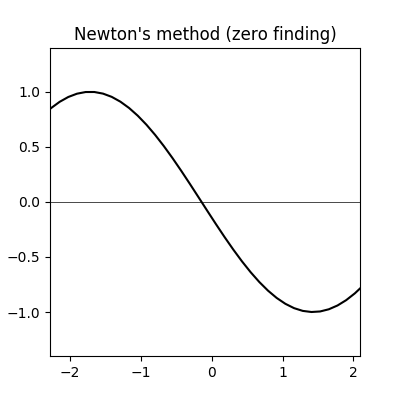
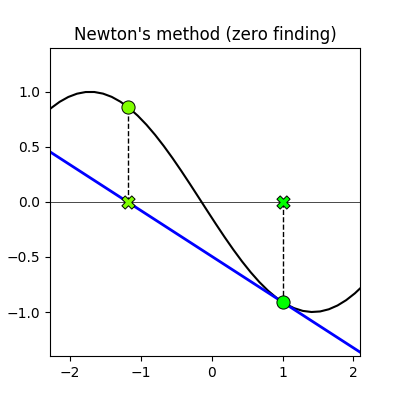
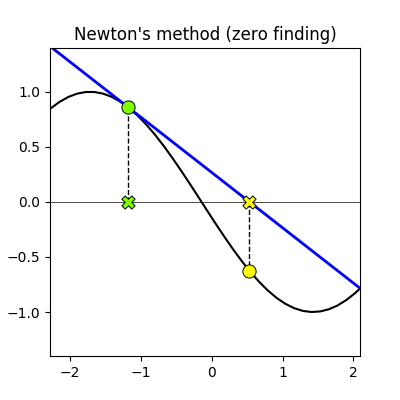
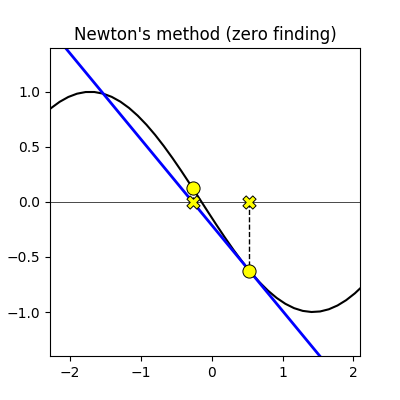
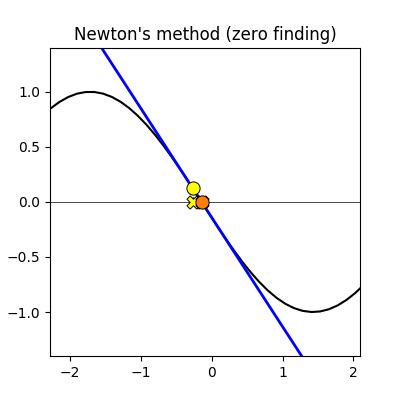
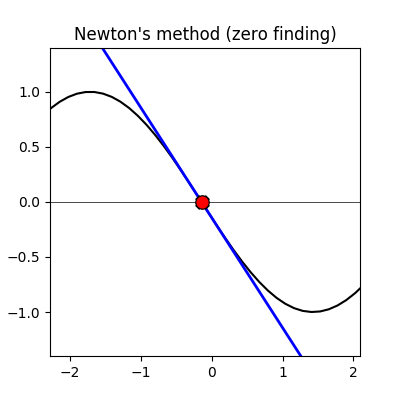
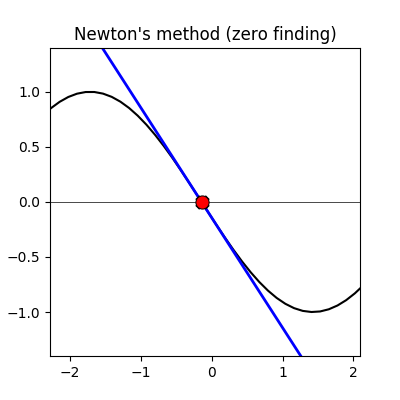

In [2]:
# what function should we play with?  Defined in the next line, along with our fixed point where we show tangency.
g = lambda w: np.sin((w - 3))

# create an instance of the visualizer with this function
st = optilearn.newton_secant_zero_finder.visualizer(g = g)

# run the visualizer for our chosen input function and initial point
st.draw_it_newton(w_init = 1)

To write out the first step of this scheme, remember first and foremost that we are thinking of this as an iterative method applied to the derivative function $g^{\prime}(w)$ (we could of course apply it to the cost function itself $g(w)$, but our goal is to find stationary points of this function!).  This means that - beginning at a point $w^0$ - that our linear approximation to the derivative function naturally involves the *second derivative*, since the [*slope* of the tangent line is always given by the derivative](https://jermwatt.github.io/mlrefined/html/pages/topics/Computational_Calculus.html) of the function we are constructing it for.  We can then write the linear approximation to the derivative at $w^0$ as

\begin{equation}
h\left(w^0\right) = g^{\prime}\left(w^0\right) + g^{\prime \prime}\left(w^0\right)\left(w - w^0\right).
\end{equation}

Then if we simply wish to see where the tangent line crosses the input axis, we set the above to zero

\begin{equation}
g^{\prime}\left(w^0\right) + g^{\prime \prime}\left(w^0\right)\left(w - w^0\right) = 0
\end{equation}

and solve for $w$.  Doing this, and calling the solution $w^1$, we have

\begin{equation}
w^1 = w^0 - \frac{g^{\prime}\left(w^0\right)}{g^{\prime \prime}\left(w^0\right) }.
\end{equation}

If we repeat these steps, the $k^{th}$ one will then take the same form as

\begin{equation}
w^k = w^{k-1} - \frac{g^{\prime}\left(w^{k-1}\right)}{g^{\prime \prime}\left(w^{k-1}\right) }.
\end{equation}

This is the formula for the $k^{th}$ Newton step!

So - indeed - we can view Newton's method simultaneously as

- a method for determining a stationary point (preferably a minimum) of a cost function $g(w)$


- a method for finding a zero of the derivative function, i.e., where  $g^{\prime}(w) = 0$


In the next cell we show an animation that - for a real input cost function - draws out the Newton steps on both the cost function and its derivative simultaneously.  As you move the slider from left to right the algorithm proceeds forward. 


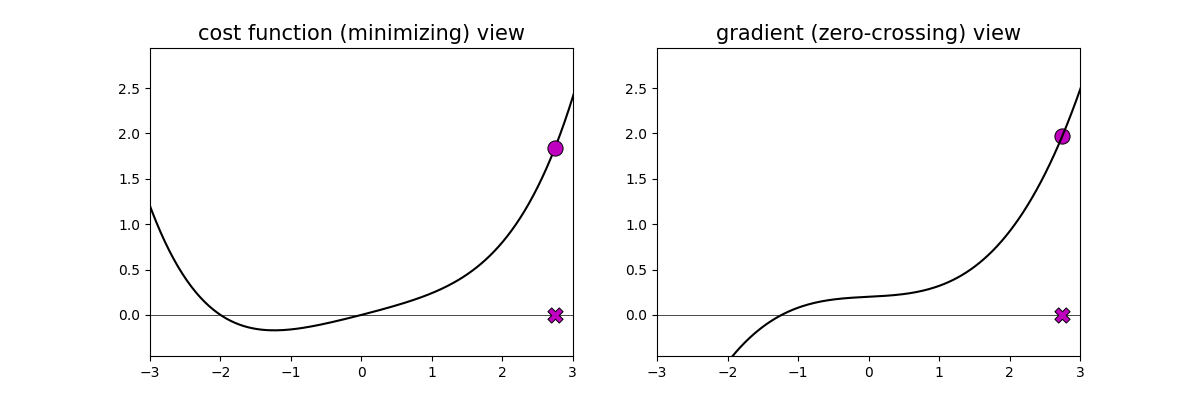
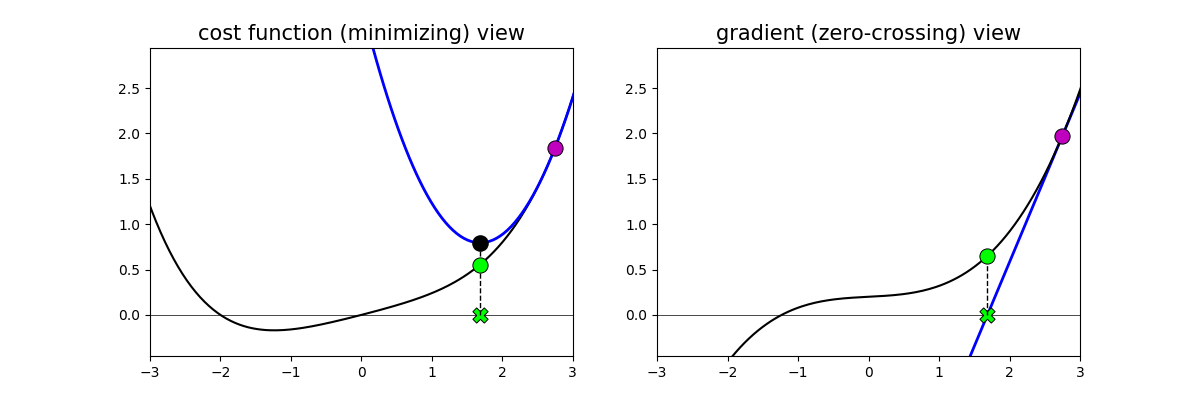
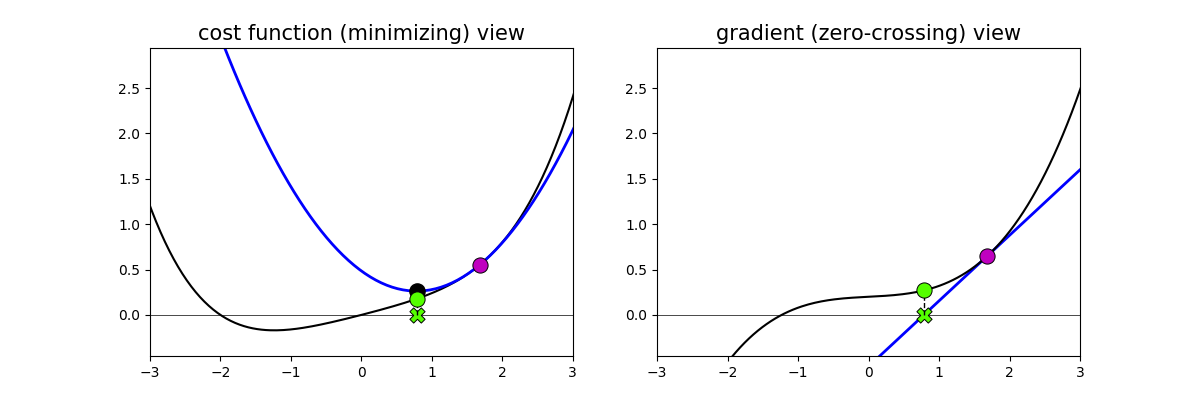
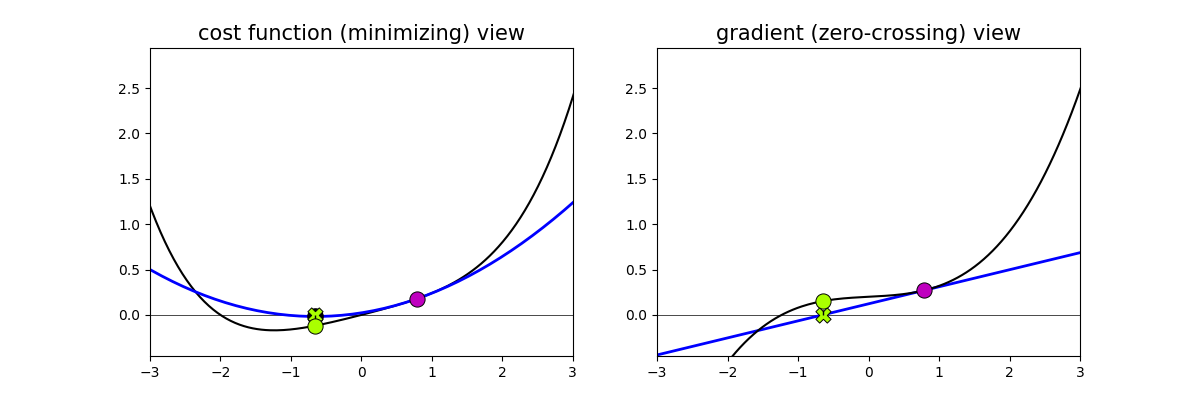
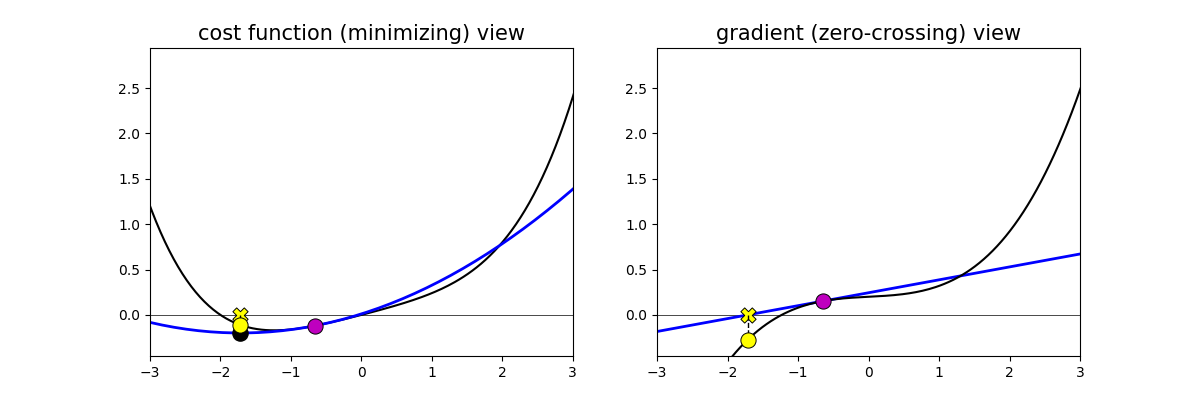
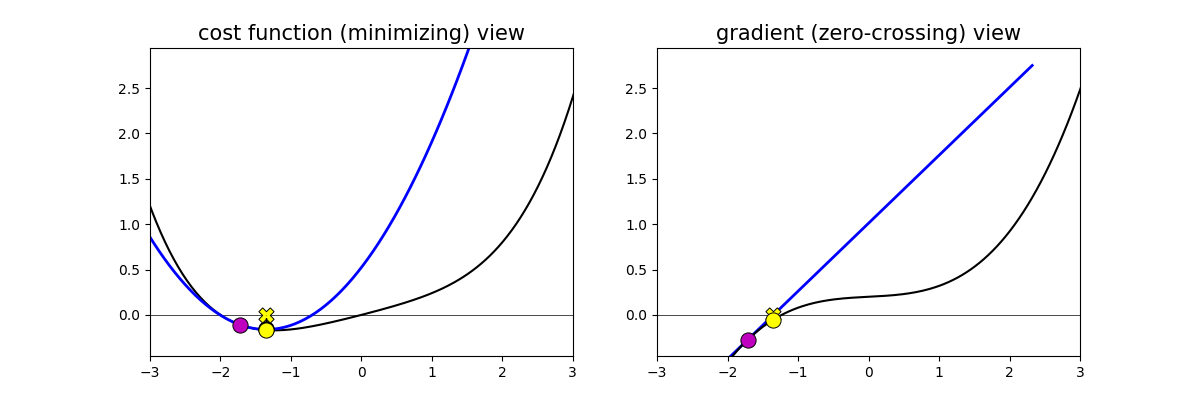
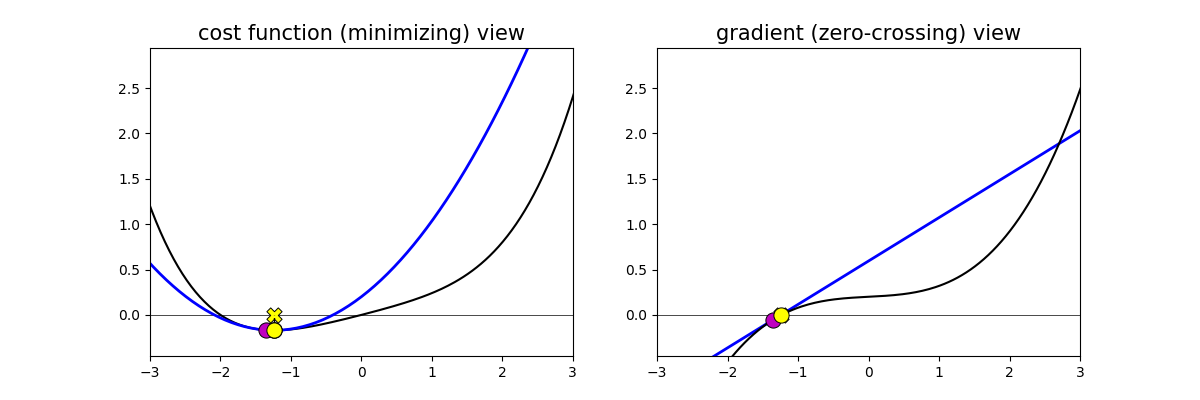
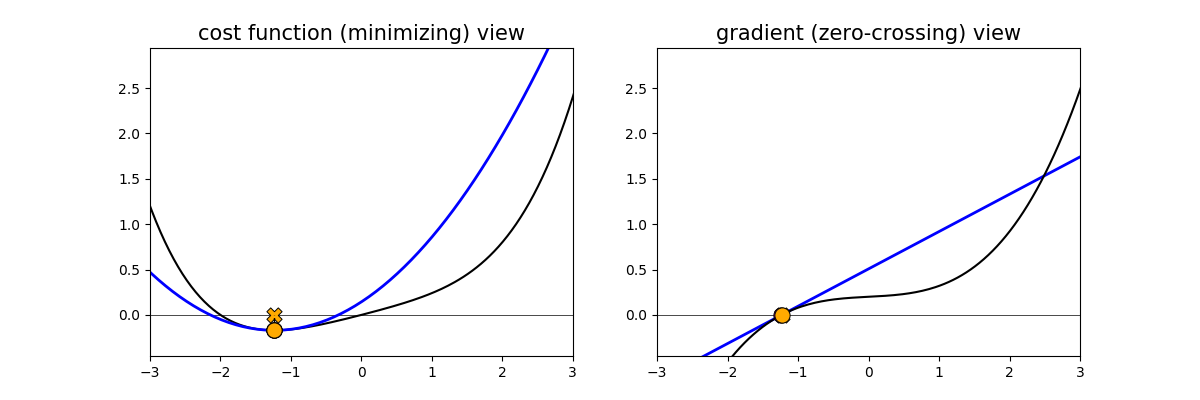
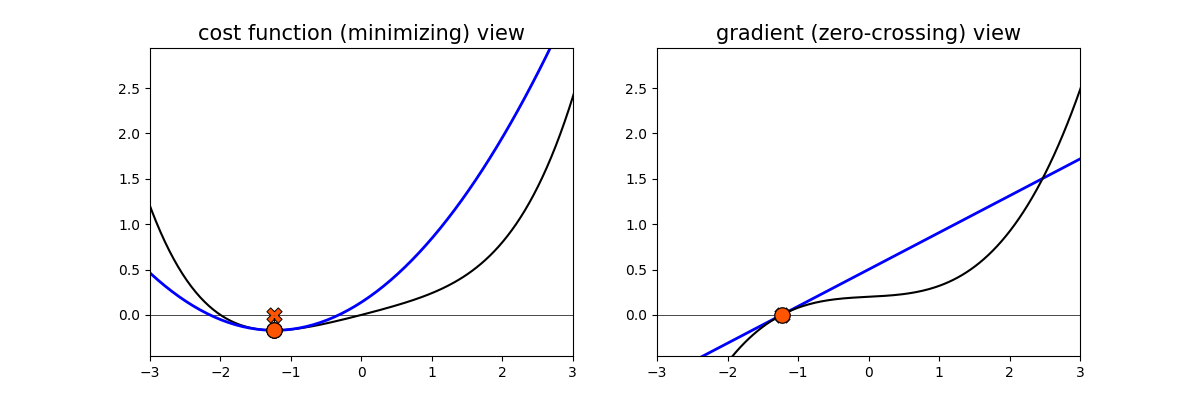
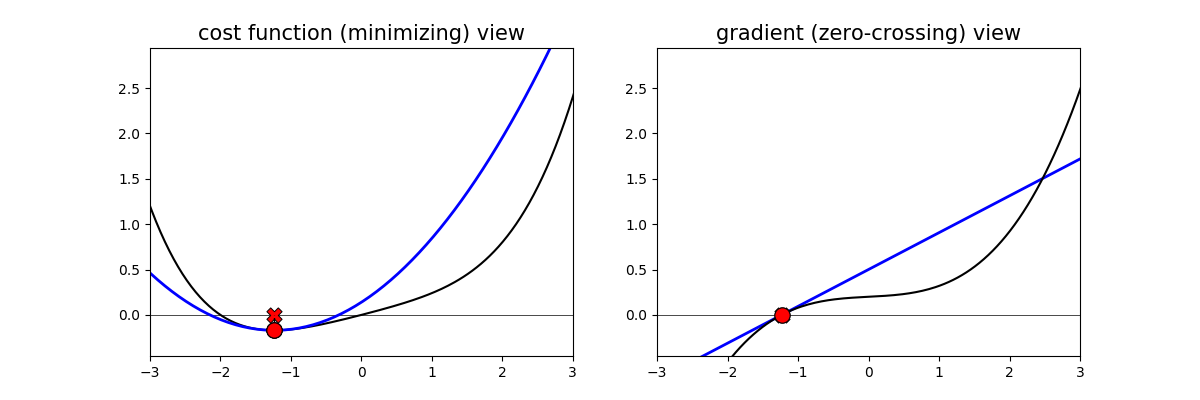

In [3]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# create an instance of the visualizer with this function
minimize_zerofind = optilearn.minimize_zero_find_simultaneous.visualizer(g = g)

# run the visualizer for our chosen input function, initial point, and step length alpha
minimize_zerofind.draw_it_newtons(w_init = 2.75,max_its = 20)

## 1.2  Approximating the second derivative and the secant method

Remember from our discussions regarding the [basic notion of a function derivative](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_1_what_are_derivatives.html), that the derivative defines the tangent line to a function at a point.  Therefore the derivative - our slope - can be roughly approximated as the slope of a nearby [*secant line*](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_2_derivatives_at_point.html).   Using this fact in our current scenario, we can then say that the slope of the tangent line to our derivative function $g^{\prime}(w)$ - this slope being the second derivative itself $g^{\prime \prime}(w)$ - can itself be approximated by the slope of a nearby secant

\begin{equation}
g^{{\prime}{\prime}}(w^{\,}) \approx \frac{g^{\prime}(w^{\,}) - g^{\prime}(v^{\,})}{w^{\,} - v^{\,}}
\end{equation}

if $v$ is taken close enough to the evaluation point $w$.  Using this rule somewhat loosely if we then go back to our Newton step and swap out the second derivative evaluation with this approximation we have a generic step that looks like

\begin{equation}
w^k = w^{k-1} - \frac{g^{\prime}\left(w^{k-1}\right)}{ \frac{g^{\prime}(w^{k-1}) - g^{\prime}(w^{k-2})}{w^{k-1} - w^{k-2}} }.
\end{equation}

This approach - called the *Secant Method* since it employs a secant instead of a tangent line - still determines zeros of the derivative function $g^{\prime}(w)$ / stationary points of the cost $g(w)$.  This approach - while slower than the pure Newton's method - has the massive benefit of not having to compute second derivatives.  This may not seem particularly helpful when dealing with $N = 1$ dimensional input cost functions, but when dealing with arbitrary dimensions it is indeed a life saver.


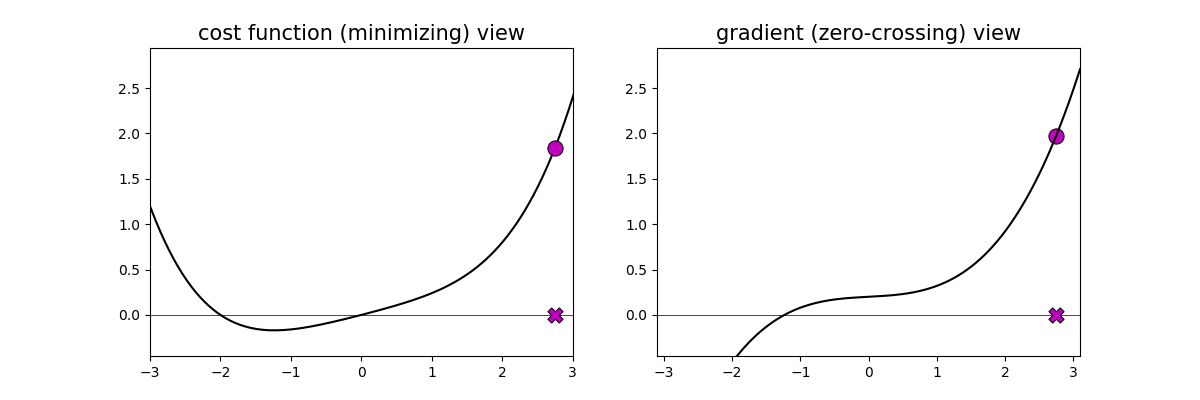
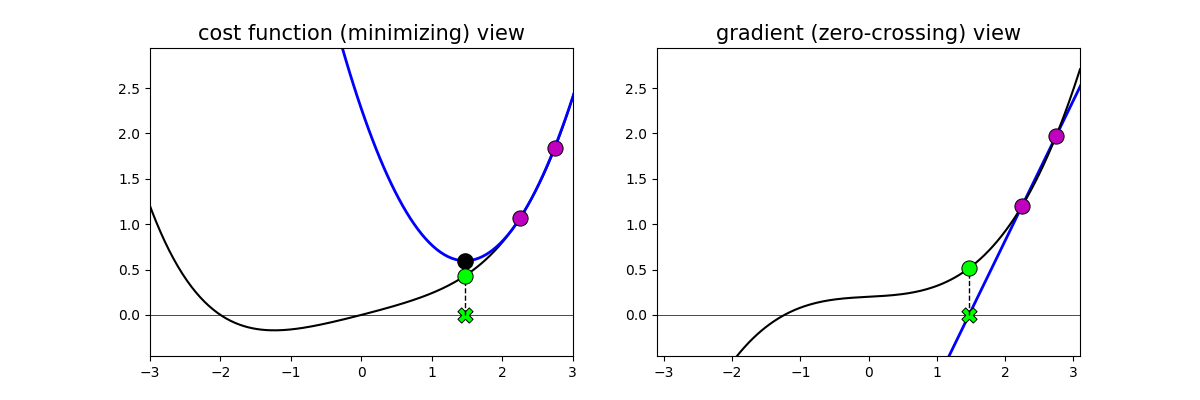
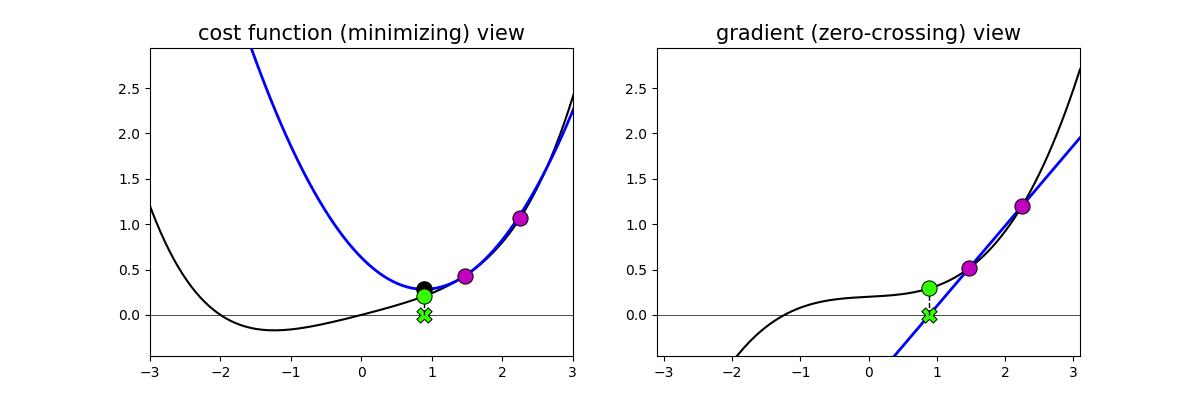
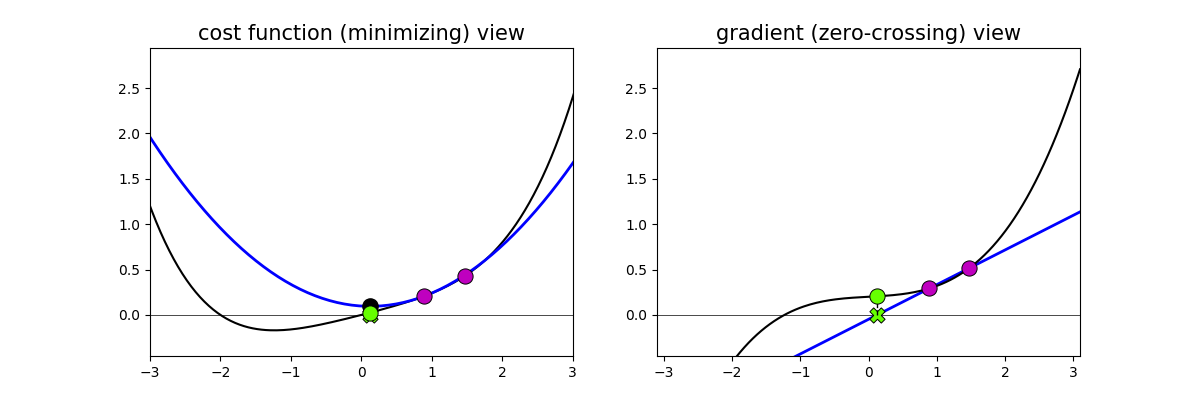
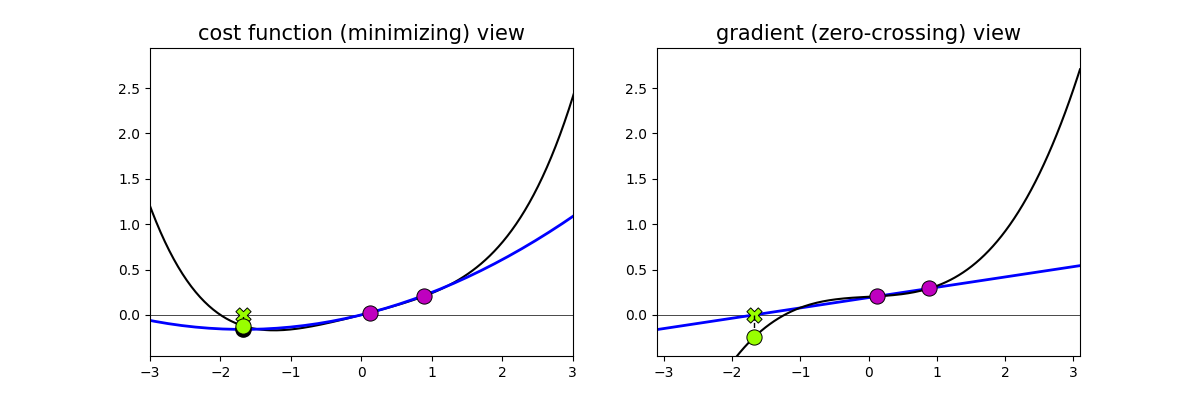
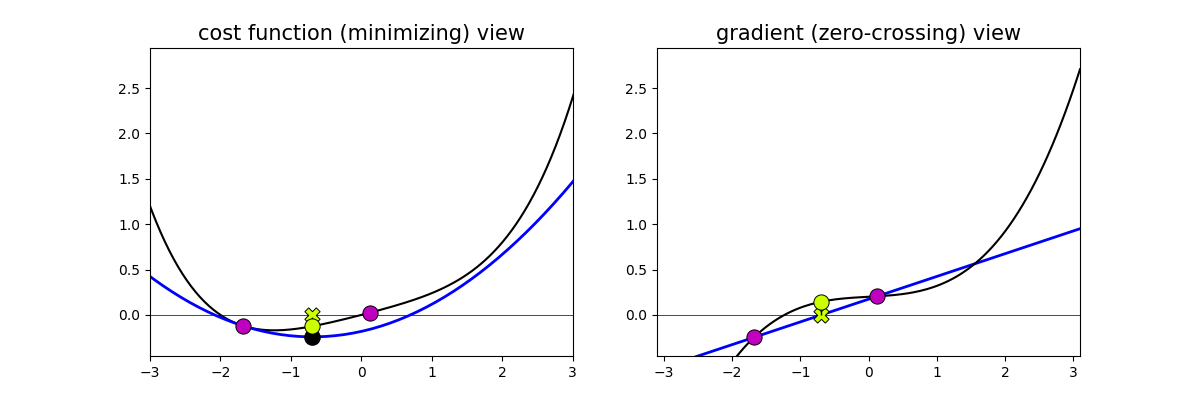
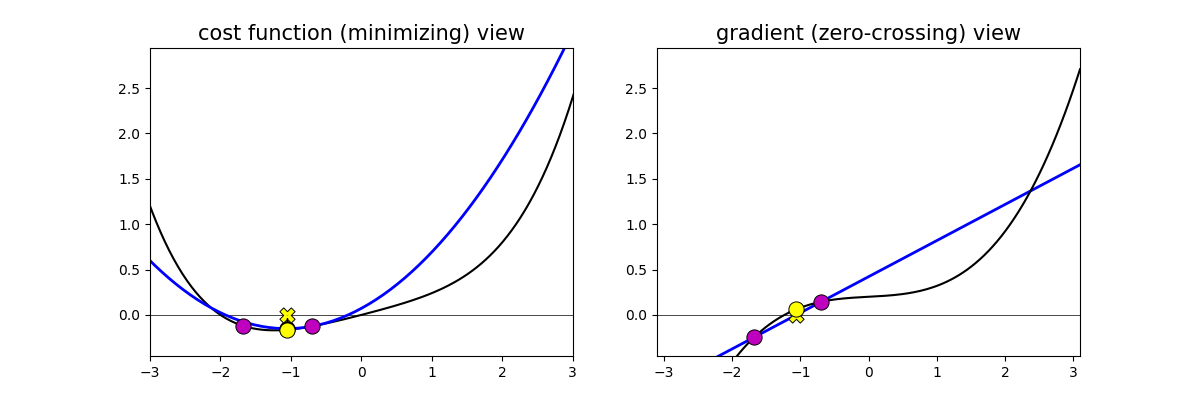
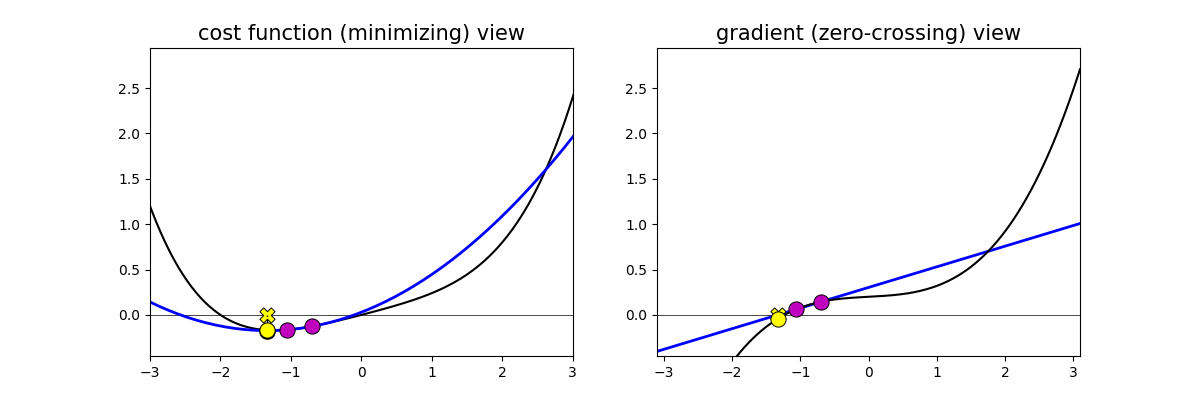
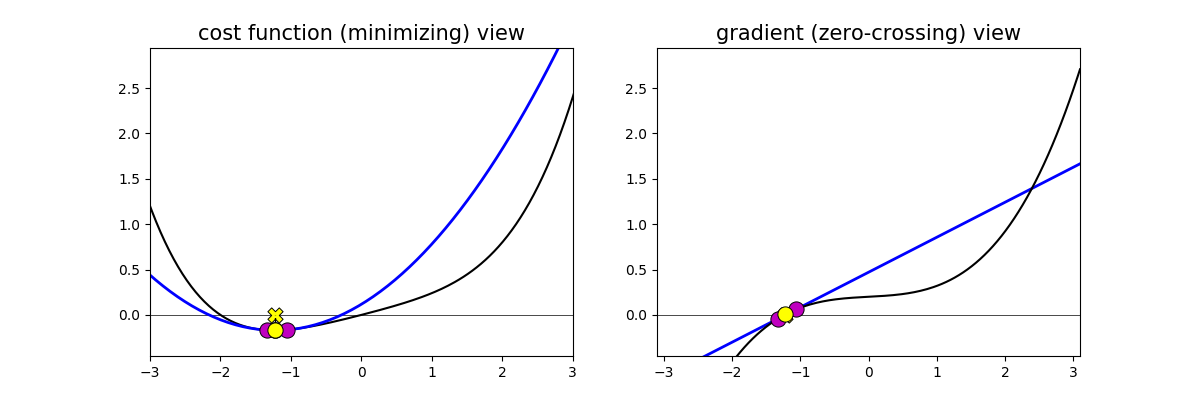
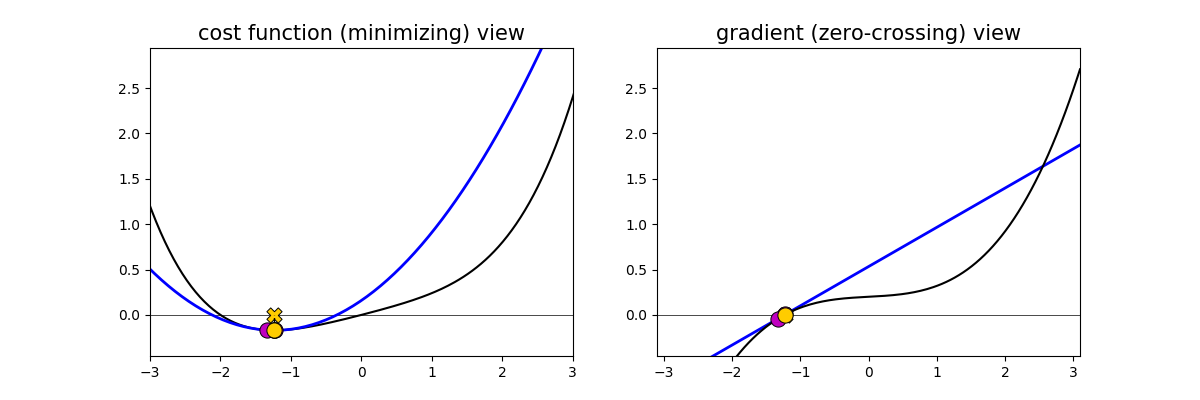
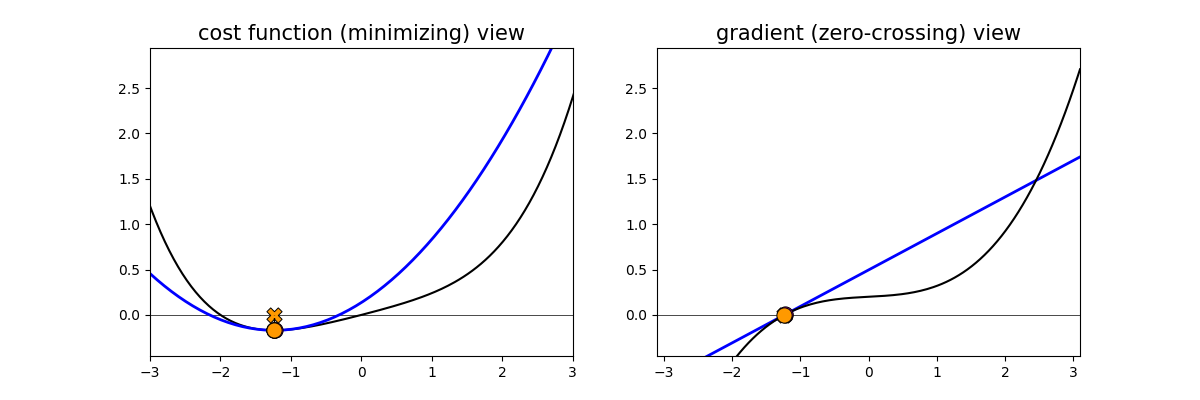
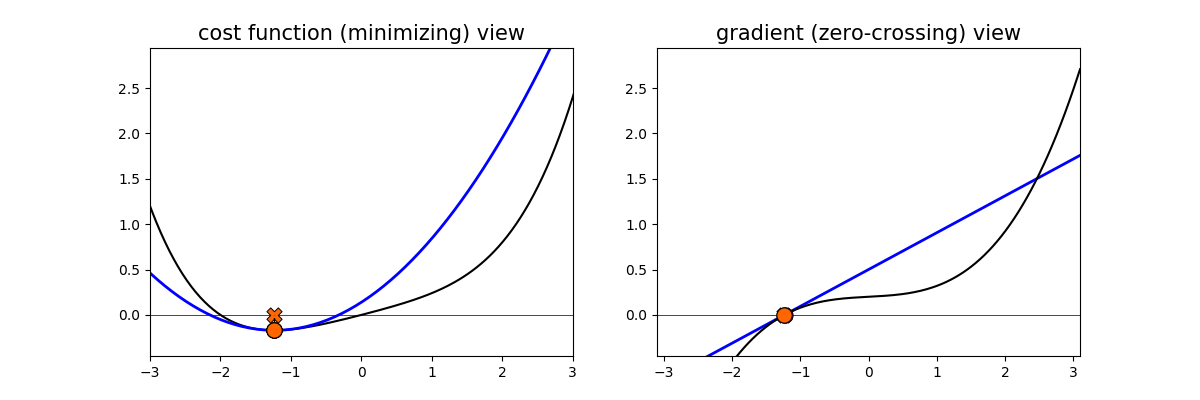
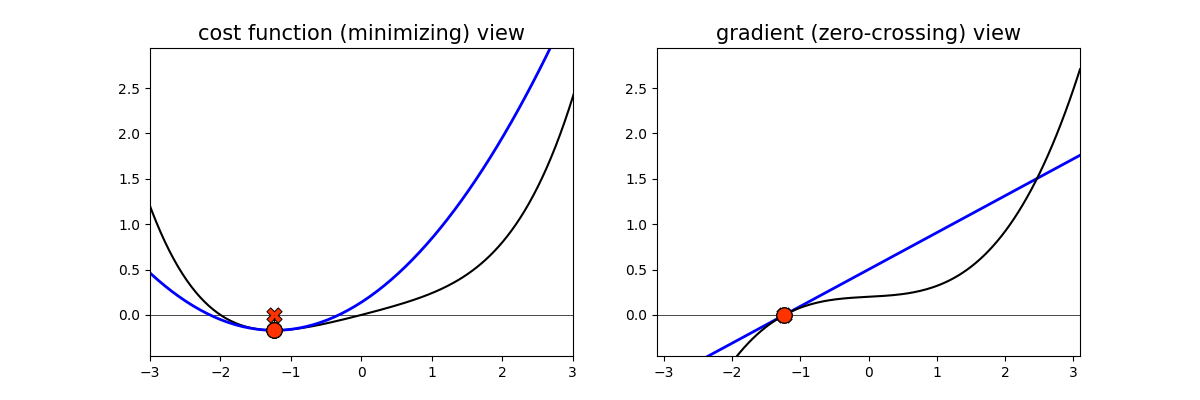

In [5]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# create an instance of the visualizer with this function
minimize_zerofind = optilearn.minimize_zero_find_simultaneous.visualizer(g = g)

# run the visualizer for our chosen input function, initial point, and step length alpha
minimize_zerofind.draw_it_secant(w_init = 2.75,max_its = 20)

## 1.3  The general $N$ dimensional input Secant Method 

Everything we have discussed for the generic $N= 1$ dimensional case tracks to the higher dimensional instance as well, with one important difference.  Suppose we take our higher dimensional Newton's method step (supposing for the moment we can invert the Hessian matrix)

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \nabla g\left(\mathbf{w}^{k-1}\right) \nabla^2 g\left(\mathbf{w}^{k-1}\right)^{-1}
\end{equation}

and swap out the Hessian with the approximation analogous to the one dimensional case where we made the substitution 

\begin{equation}
g^{\prime \prime}(w^{k-1}) \longleftarrow s^k = \frac{g^{\prime}(w^{k-1}) - g^{\prime}(w^{k-2})}{w^{k-1} - w^{k-2}}
\end{equation}

What is this approximation?   Abusing notation we could express it as (this is incorrect mathematically speaking, but the algebra mirrors the one dimensional case) as 

\begin{equation}
\nabla^2 g\left(\mathbf{w}^{k-1}\right) \longleftarrow \mathbf{S}^k = \frac{\nabla g\left(\mathbf{w}^{k-1}\right) - \nabla g\left(\mathbf{w}^{k-2}\right)}{\mathbf{w}^{k-1} - \mathbf{w}^{k-2}}.
\end{equation}

Again - while the way we have written the line above is nice in that it mirrors the single-dimensional case it does not make sense.  Every quantity on the right hand side is an $N\times 1$ vector, so we cannot actually compute the quotient on the right hand side above.  The proper $N$ dimensional analog of equation (11) is the *linear system*

\begin{equation}
\nabla^2 g\left(\mathbf{w}^{k-1}\right) \longleftarrow \mathbf{S}^{k}\left(\mathbf{w}^{k-1} - \mathbf{w}^{k-2}\right)  =   \nabla g\left(\mathbf{w}^{k-1}\right) - \nabla g\left(\mathbf{w}^{k-2}\right).
\end{equation}


Here $\mathbf{S}^{k}$ is an $N\times N$ matrix we must solve for.

In other words, unlike the $N = 1$ dimensional case - where each update has a closed form update - in higher dimensions we have a linear system to solve, which may have multiple solutions.